# Train and deploy a neuronal network in the AWS cloud

In the following notebook is shown how to train and deploy a Keras Neuronal Network model. This Neuronal Network is going to serve as an inference engine endpoint at AWS Sagemaker. The model is going to be triggered from a Lambda function when new values from a field sensor arrives.


As field soft sensor, a [RMG/941](https://www.ssv-embedded.de/produkte/rmg941.php) is used.

### Step 1:

Import general libraries and import files from S3. The files are stored in a compressed .tgz file. These files where uploaded to S3 with the PyDSlog app from the RMG/941 gateway.

The Bucket is the same as the defined when the files were uploaded to S3 from the soft sensor and the prefix is a timestamp that is used at the same time as folder name.

In [1]:
import json
import numpy as np
import pandas as pd
import boto3
import tarfile
import sagemaker


BUCKET = "<bucket>" 
PREFIX = "<prefix>"

# download files from s3 to sagemaker
s3 = boto3.client('s3')
s3.download_file(BUCKET, PREFIX+".tgz", PREFIX+".tgz")

Since the files are loaded in a compressed .tgz file, they must be unpacked before the signals can be read.
The config.cfg file stores configurations parameters like frequency of the sensor and the length of the signals. These configurations are needed for the FFT transformation.

In [2]:
# extract tar files
tar = tarfile.open(PREFIX+".tgz")
tar.extractall()
tar.close()

# read config
with open(PREFIX+"/"+"config.cfg") as f:
    config = str(f.read())
    
config = json.loads(config)

sig      = bool(config["save_as_signal"])
channels = list(config["channels"])
freq     = int(config["frequency"])
N        = int(config["frame_size"])

X_FILES = ["x_"+n+"_.csv" for n in channels]


# read signals into numpy arrays
signals = []
for file in X_FILES:
    data_location = PREFIX+"/"+file
    s = np.array(pd.read_csv(data_location, header=None, index_col=None))
    signals.append(s)
signals = np.transpose(np.array(signals), (1, 0, 2))

# read labels into numpy arrays
Y_FILE = "y_.csv"
data_location = PREFIX+"/"+Y_FILE
labels = np.array(pd.read_csv(data_location, header=None, index_col=None))
labels = np.squeeze(labels)


# print shapes
print("Labels shape")
print(labels.shape)
print("Signals shape")
print(signals.shape)

print("Different labels in dataset:")
diff_labels = np.unique(labels)
print(diff_labels)

Labels shape
(398,)
Signals shape
(398, 6, 600)
Different labels in dataset:
[0 1 2]


Configurations are loaded with the signal files in the AWS S3 Bucket. You can see the channels, Data source, frequency and the length of the signals.

In [3]:
print(config)

{'frequency': '300', 'save_as_signal': 'True', 'frame_size': '600', 'channels': ['ACCX', 'ACCY', 'ACCZ', 'GYRX', 'GYRY', 'GYRZ'], 'labeled': 'True', 'source': 'MLS/160A'}


### Step 2:

See how the data looks like. It is possible to see differences between the signals of differents classes?

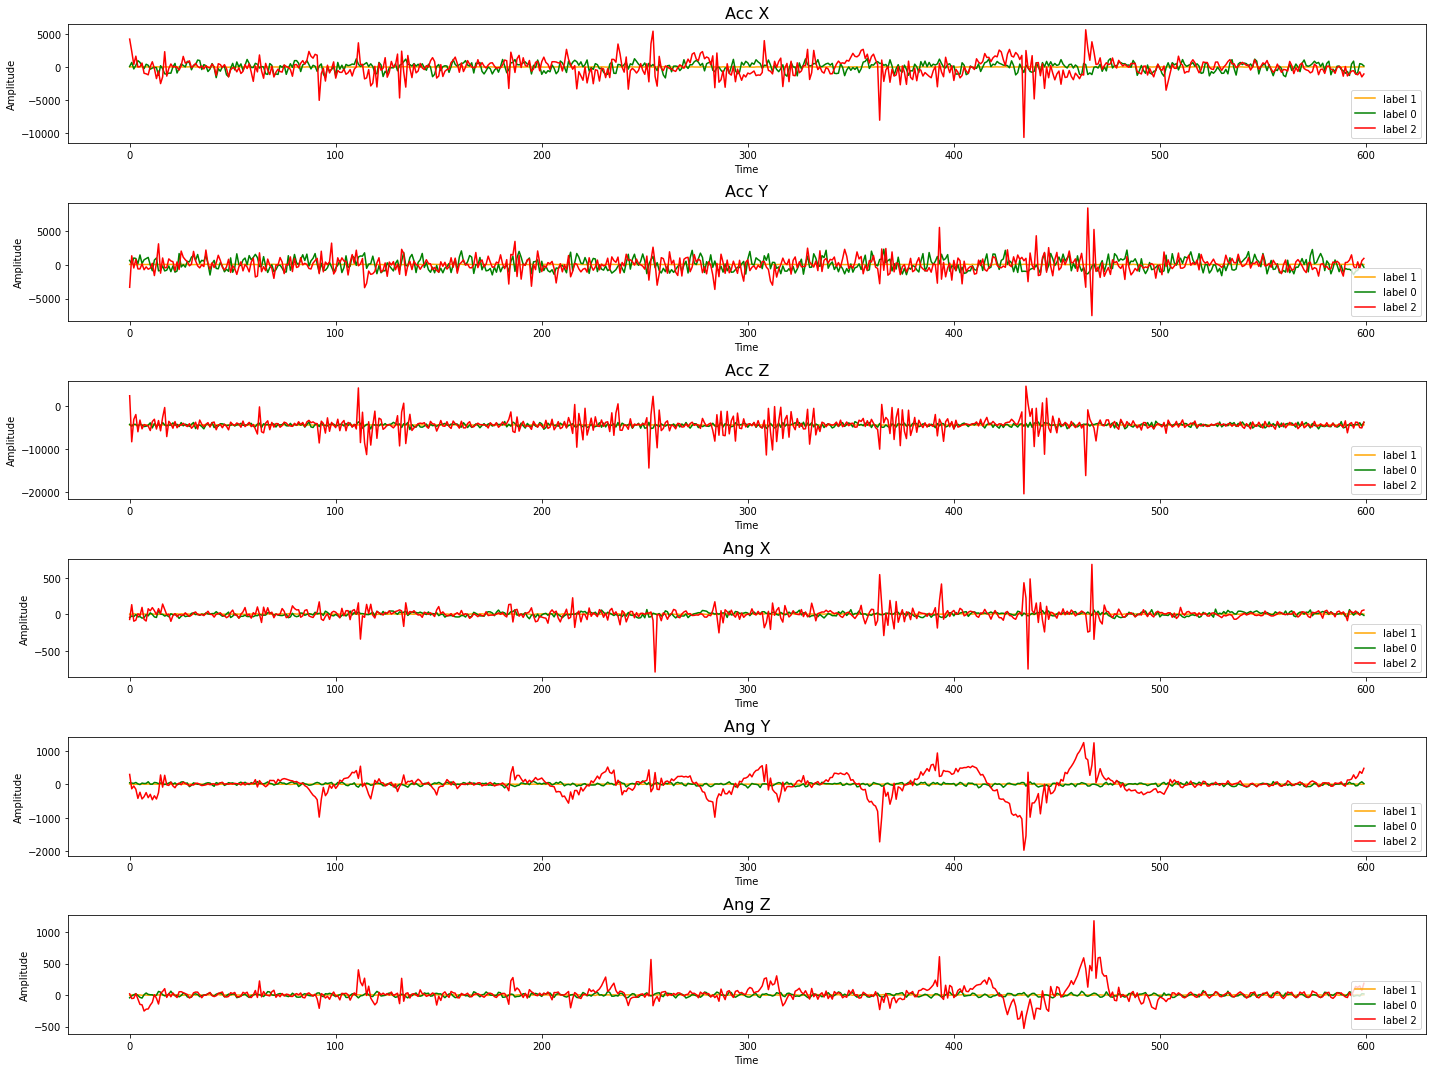

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(20, 15))

signals_to_show = [10, 200, 350]
colors = ["orange", "green", "red"]
titles = ["Acc X", "Acc Y", "Acc Z", "Ang X", "Ang Y", "Ang Z"]

for c in range(signals.shape[1]):
    for s in range(len(signals_to_show)):
        ax[c].plot(signals[signals_to_show[s],c,:], linestyle='-', color=colors[s], 
                   label="label "+str(labels[signals_to_show[s]]))
    ax[c].legend(loc='lower right')
    ax[c].set_title(titles[c], fontsize=16)
    ax[c].set_xlabel('Time', fontsize=10)
    ax[c].set_ylabel('Amplitude', fontsize=10)

fig.tight_layout()
plt.show()
        

### Step 3:
Transform the dataset. since the datasets are signals, a [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) is going to be used for the transformation. These transformations are used as Features.

In [14]:
import scipy.signal as signal
from scipy.fftpack import fft

def do_FFTs(values, freq, length, delete_offset=True):
    
    period = 1.0/freq

    _ffts = []
    for n in range(0, values.shape[0]):
        _c = []
        for c in range(0, values.shape[1]):

            v = values[n,c,:]

            if delete_offset:
                v = signal.detrend(v, type == 'constant')

            freq_v = np.linspace(0.0, 1.0 / (2.0 * period), length // 2)
            fft_v_ = fft(v)
            fft_v = 2.0 / length * np.abs(fft_v_[0:length // 2])

            xy_v = np.vstack((freq_v, fft_v)).T
            _c.append(xy_v)
        _ffts.append(_c)      
        
    return np.array(_ffts)


fft_values = do_FFTs(signals, freq, N,)

# dimensions are (n of ffts, n of components, length of ffts, time and amplitude values)
#print("FFTs shape : ",fft_values.shape)

fft_amplitudes = fft_values[:,:,:,1]
print("FFTs shape : ",fft_values.shape)

FFTs shape :  (398, 6, 300, 2)


### Step 4:

Visualize how the transformations looks like. See if there are differences between the different classes.

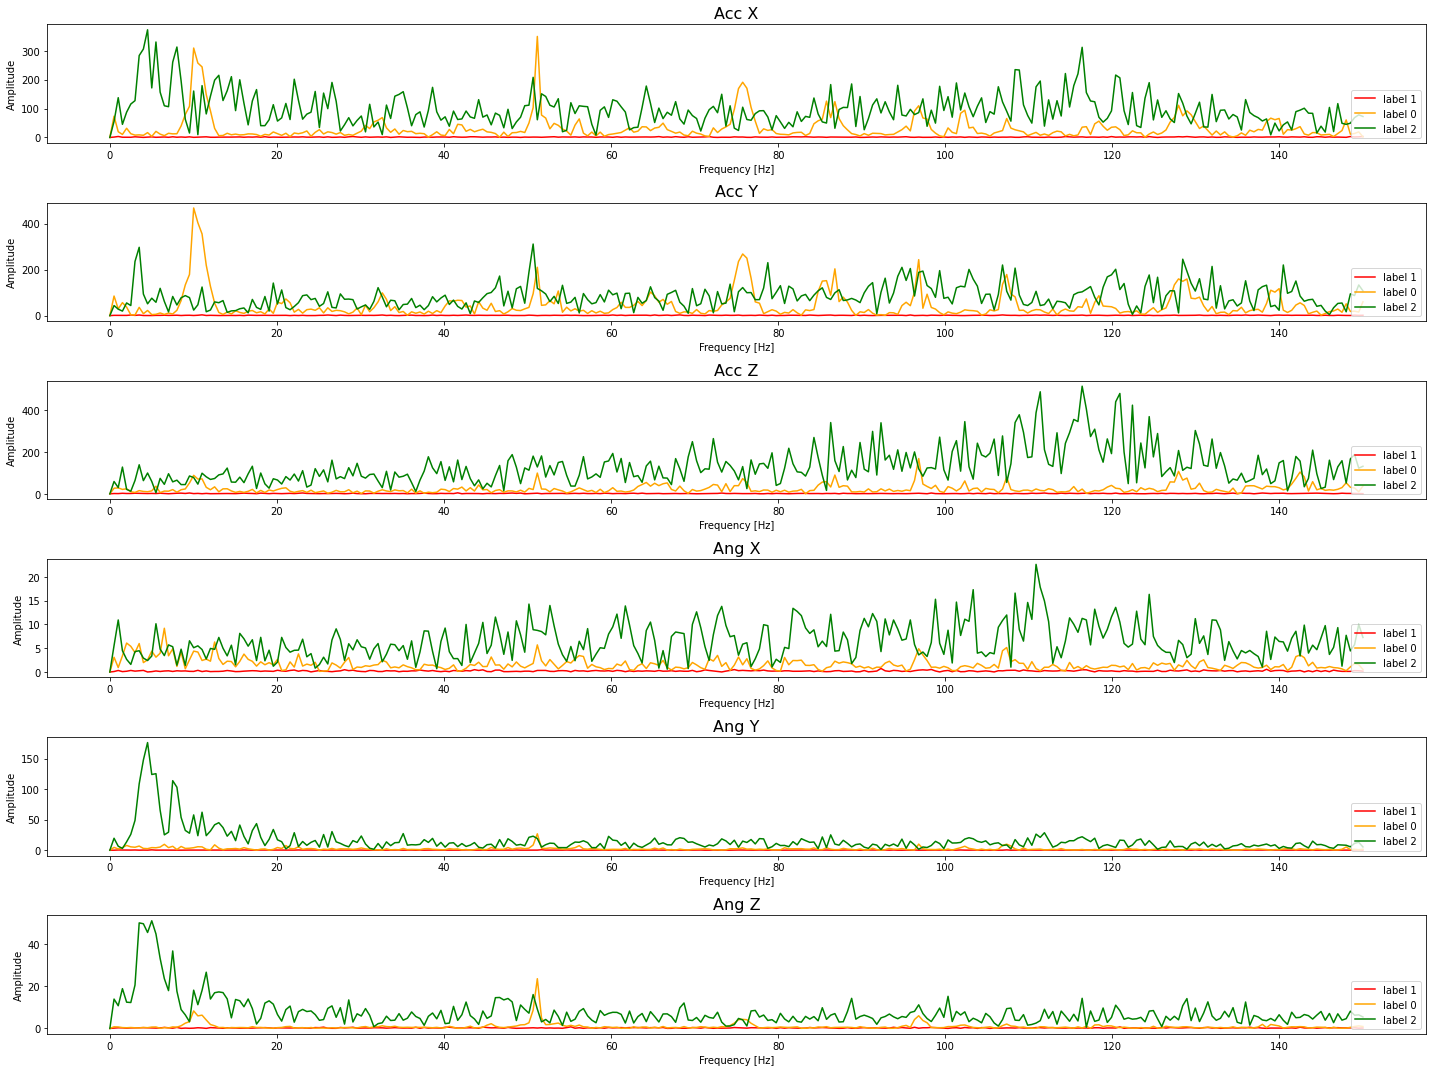

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(20, 15))

#signals_to_show = [10, 180, 390]
colors = ["red", "orange", "green"]
titles = ["Acc X", "Acc Y", "Acc Z", "Ang X", "Ang Y", "Ang Z"]

for c in range(signals.shape[1]):
    for s in range(len(signals_to_show)):
        ax[c].plot(fft_values[signals_to_show[s],c,:,0], fft_values[signals_to_show[s],c,:,1], linestyle='-', color=colors[s], 
                   label="label "+str(labels[signals_to_show[s]]))
    ax[c].legend(loc='lower right')
    ax[c].set_title(titles[c], fontsize=16)
    ax[c].set_xlabel('Frequency [Hz]', fontsize=10)
    ax[c].set_ylabel('Amplitude', fontsize=10)

fig.tight_layout()
plt.show()

### Step 5:
Train and test split.
Split the Features in a training dataset and a test dataset. Here the split is 40% for testing and 60% for training.

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(fft_amplitudes, labels, test_size=0.4,
                                                    random_state=42, stratify=labels)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

print("train shape: ",x_train.shape)
print("train labels shape: ",y_train.shape)
print("test shape: ",x_test.shape)
print("labels shape: ",y_test.shape)

train shape:  (238, 1800)
train labels shape:  (238,)
test shape:  (160, 1800)
labels shape:  (160,)


### Step 6:
generate a model

In [12]:
# Import Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Change the label to fit the NN. Converts a class vector (integers) to binary class matrix.
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)


dimensions_in = x_train.shape[1]
dimensions_out = y_train.shape[1]

# Define neuronal network and train.
model = keras.Sequential()
model.add(layers.Dense(100, input_shape=(dimensions_in,), activation='sigmoid'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='sigmoid'))
model.add(layers.Dense(dimensions_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train, y_train, batch_size=100, epochs=250, 
          validation_data=(x_test, y_test), verbose=1)



(238, 3)
(160, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               180100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 190,503
Trainable params: 190,503
Non-trainable params: 0
_________________________________________________________________
None
Train on 238 samples, validate on 160 samples
Epoch 1/250
238/238 [==============================] - 0s 2ms/sample - loss: 1.0521 - acc: 0.5210

Epoch 108/250
238/238 [==============================] - 0s 70us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9812
Epoch 109/250
238/238 [==============================] - 0s 79us/sample - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9812
Epoch 110/250
238/238 [==============================] - 0s 83us/sample - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9812
Epoch 111/250
238/238 [==============================] - 0s 86us/sample - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9812
Epoch 112/250
238/238 [==============================] - 0s 81us/sample - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9812
Epoch 113/250
238/238 [==============================] - 0s 79us/sample - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9812
Epoch 114/250
238/238 [==============================] - 0s 71us/sample - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9812
Epoch 115/250
238/238 [===========

238/238 [==============================] - 0s 74us/sample - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0742 - val_acc: 0.9812
Epoch 227/250
238/238 [==============================] - 0s 77us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9812
Epoch 228/250
238/238 [==============================] - 0s 73us/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0745 - val_acc: 0.9812
Epoch 229/250
238/238 [==============================] - 0s 93us/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9812
Epoch 230/250
238/238 [==============================] - 0s 78us/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0751 - val_acc: 0.9812
Epoch 231/250
238/238 [==============================] - 0s 82us/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 0.9812
Epoch 232/250
238/238 [==============================] - 0s 82us/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9812
Epoch 233/250
238/238 [=========================

Plot the training history.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


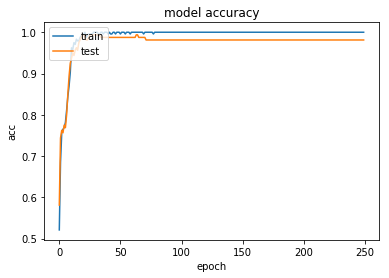

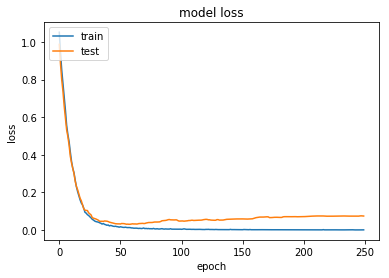

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

See how the model performance is.

In [14]:
from sklearn.metrics import classification_report

predictions = model.predict(x_test)    
print(classification_report(y_test.argmax(-1), predictions.argmax(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.95      1.00      0.98        61
           2       1.00      0.92      0.96        38

    accuracy                           0.98       160
   macro avg       0.98      0.97      0.98       160
weighted avg       0.98      0.98      0.98       160



Reset model if new training job is desired.

In [15]:
#keras.backend.clear_session()

### Step 7:
Export the Keras model to the Tensorflow Protobuf format

In [16]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Note: This directory structure will need to be followed
model_version = '1'
export_dir = 'export/Servo/' + model_version

# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(inputs={"inputs": model.input}, outputs={"score": model.output})
from tensorflow.keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(sess=sess, tags=[tag_constants.SERVING], 
                                         signature_def_map={"serving_default": signature})
    builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


### Step 8:
Convert TensorFlow model to an Amazon SageMaker-readable format.

Move the TensorFlow exported model into a directory export\Servo. Amazon SageMaker will recognize this as a loadable TensorFlow model. Your directory and file structure should look like this:

In [17]:
#rm -rf export # if modell was created before, you can removed

In [18]:
!ls export

Servo


In [19]:
!ls export/Servo

1


In [20]:
!ls export/Servo/1/variables

variables.data-00000-of-00001  variables.index


Tar the entire directory and upload to Amazon S3

In [21]:
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

role = sagemaker.get_execution_role()

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Step 9:
Deploy the trained model.

The entry_point file train.py can be an empty Python file.

In [22]:
!touch train.py

In [23]:
from sagemaker.tensorflow.model import TensorFlowModel

sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

2.1.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [24]:
%%time

import time

endpoint_name = "ssv-sagemaker-"+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print(endpoint_name)

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium",
                                  endpoint_name= endpoint_name)

ssv-sagemaker-2020-04-17-13-07-03
-------------!CPU times: user 617 ms, sys: 44.3 ms, total: 661 ms
Wall time: 6min 31s


In [25]:
from sagemaker.tensorflow.model import TensorFlowModel

predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

### Test the model

Step 6. Invoke the endpoint

Invoke the Amazon SageMaker endpoint from the notebook

In [26]:
data = np.random.randn(1,1800)
r = predictor.predict(data)

output_list = r["outputs"]["score"]["float_val"]
y = np.array(output_list).argmax(axis=-1)

print(y)

0


Invoke the Amazon SageMaker endpoint using a boto3 client

In [27]:
data = np.random.randn(1,1800)
data = data.tolist() 

#endpoint_name = "" # variable with name defined in cell above

client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(EndpointName=endpoint_name, Body=json.dumps(data))
response_body = response['Body']
bstr = response_body.read().decode("utf-8") 
    
dbstr = eval(bstr)
output_list = dbstr["outputs"]["score"]["floatVal"]
y = np.array(output_list).argmax(axis=-1)

print(output_list)
print(y)

[0.7774079442024231, 0.0891508087515831, 0.1334412842988968]
0


### Delete the endpoint

In [28]:
#predictor.delete_endpoint()